## Part 1: Density Based Model - Local Outlier Factor (LOF)

<Figure size 432x432 with 0 Axes>

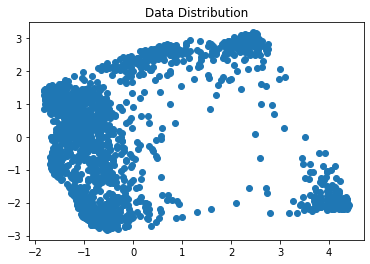

<Figure size 432x432 with 0 Axes>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

# Load data
data_frame = pd.read_csv('data.csv')
X = data_frame[['x', 'y']].values

# Data distribution visualization
plt.scatter(X[:, 0], X[:, 1]) # Plot data points distribution
plt.title('Data Distribution') 
plt.figure(figsize=(6,6))

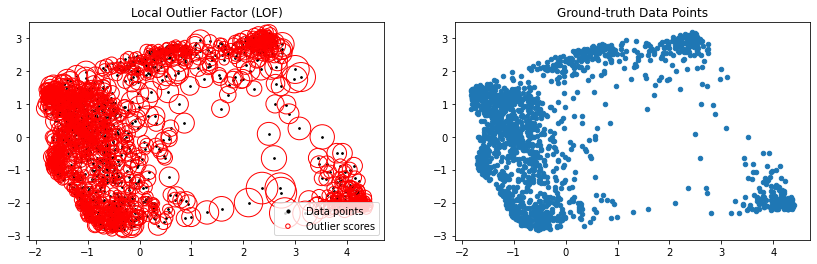

In [2]:
# Fit the model for outlier detection
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# Use fit_predict to compute the predicted labels of the training samples
y_pred = clf.fit_predict(X)
X_scores = -clf.negative_outlier_factor_ # High LOF: Outliers, Low LOF: Inliers.

# Initialize the subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].set_title("Local Outlier Factor (LOF)")
axs[0].scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores - X_scores.min()) / (X_scores.max() - X_scores.min())
axs[0].scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
legend = axs[0].legend(loc='lower right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]

# Compare with ground-truth. Grey: inliers, Red: outliers.
axs[1].set_title("Ground-truth Data Points")
axs[1].scatter(X[:, 0], X[:, 1], s=20, cmap='Set1')

## Part 2: Statistical Approach

In [3]:
meanValue = np.mean(X, axis=0)
covValue = np.cov(X.T)
print('Mean:\n', meanValue)
print ('Cov:\n', covValue)

Mean:
 [-0.02731561  0.0443381 ]
Cov:
 [[3.03798117 0.01502318]
 [0.01502318 3.0425274 ]]


In [2]:
import scipy as sp
# Define the Mahalanobis distance calculation function
def mahalanobis(x=None, data=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    """
    x_minus_mu = x - np.mean(data, axis=0)
    cov = np.cov(data.T)
    
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Mahalanobis distance Calculation
anomaly_score = mahalanobis(x=X, data=X)

# Rank the anomaly scores (Descending)
n=10 # also try n=20 to see if there are any errors
anom = pd.DataFrame(anomaly_score, index=data_frame.index, columns=['Anomaly score'])
result = pd.concat((data_frame,anom), axis=1)
result.nlargest(n,'Anomaly score') # Labels with -1: outliers, 1: inliers

,x,y,Anomaly score
1487,4.37,-2.19,8.037843
1715,4.39,-2.12,7.993810
266,4.40,-2.08,7.966035
30,4.34,-2.17,7.921544
1342,4.34,-2.17,7.921544
1317,4.33,-2.17,7.892753
1620,4.39,-2.04,7.880944
1687,4.37,-2.06,7.850599
1082,4.32,-2.15,7.834764
229,4.34,-2.10,7.820267


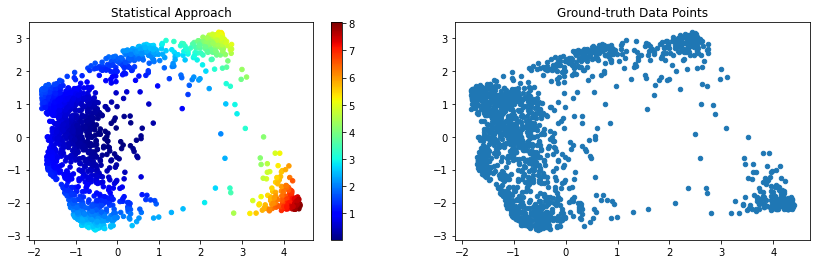

In [5]:
# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(14, 4)) # Initialize the subplots
axs[0].set_title("Statistical Approach")
im1 = axs[0].scatter(data_frame.x,data_frame.y,  s=20, c=anomaly_score,cmap='jet')
fig.colorbar(im1,ax=axs[0])

axs[1].set_title("Ground-truth Data Points")
im2 = axs[1].scatter(data_frame.x,data_frame.y, s=20, cmap='Set1')

## Part 3: Distance-based Approach

In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance

# Find the k-NearestNeighbours (kNN)
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(X)
distances, indices = nbrs.kneighbors(X)

# Anomaly_score: distance between data points and their k-th nearest neighbor
anomaly_score = distances[:,knn-1]

# Print top predicted outliers
n=10 # also try n=20 to see if there are any errors
anom = pd.DataFrame(anomaly_score, index=data_frame.index, columns=['Anomaly score'])
result = pd.concat((data_frame,anom), axis=1)
result.nlargest(n,'Anomaly score') # -1: outliers, 1: inliers

,x,y,Anomaly score
792,2.590,-0.65600,0.889870
420,1.560,0.85200,0.815927
701,2.490,0.08590,0.748609
1593,2.100,-2.00000,0.697782
1229,2.710,-1.56000,0.668506
1412,1.580,-2.19000,0.636180
1598,3.520,-0.00745,0.629825
1615,3.080,0.25100,0.612665
1025,2.800,-2.32000,0.596657
1203,0.756,0.99100,0.588804


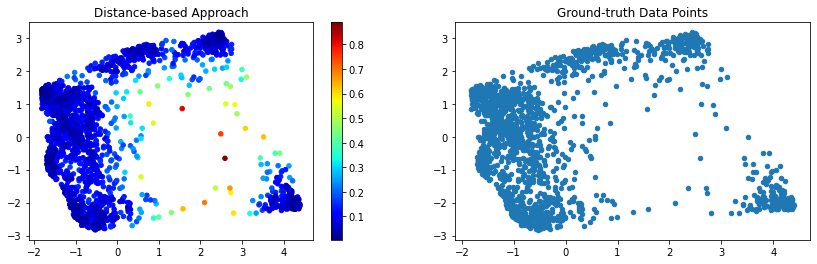

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4)) # Initialize the subplots

axs[0].set_title("Distance-based Approach")
im1 = axs[0].scatter(data_frame.x,data_frame.y,  s=20, c=anomaly_score,cmap='jet')
fig.colorbar(im1,ax=axs[0])

axs[1].set_title("Ground-truth Data Points")
im2 = axs[1].scatter(data_frame.x,data_frame.y, s=20, cmap='Set1')

## k-mean

In [92]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state= 1) # Set the total number of the cluster, i.e, k,to be 8
# ***Note that for running k-means, the first step is to randomly select several data points as the "initial" center points. 
# ***Thus we fix the random_state to be the random seed 1, such that the results can be reproducible. 

kmeans.fit(X) # Compute k-means clustering
y_kmeans = kmeans.predict(X) # Allocate the data points to a specific cluster

In [93]:
from sklearn import metrics
labels = kmeans.fit(X).labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.574


In [28]:
# Let us calculate the SSE according to the definition
centers = kmeans.cluster_centers_ # get the clustering centers

label = 0; 
SSE = 0;
for center in centers: # for each cluster center
    X_current_cluster = X[y_kmeans==label] # get the data in the cluster
    for x in X_current_cluster: # for each data
        SSE = SSE + pow(np.linalg.norm((x - center)),2) 
        # calcualte the square of distance and add to SSE
    label=label+1; # update the label for the next cluster

print('SSE of the kmeans clustering by hand-written code is, ' + str(SSE))

SSE of the kmeans clustering by hand-written code is, 3178.5602034489184


Text(0.5, 1.0, 'Clustering Result')

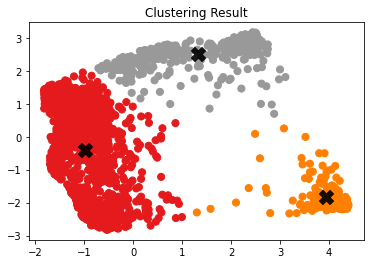

In [27]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='Set1') # Plot data points based on the cluster allocation
centers = kmeans.cluster_centers_ # Get cluster center info 
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=200, alpha=0.9); # Plot the cluseter center as the black X
plt.title('Clustering Result')

In [159]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state = 3) # Set the total number of the cluster to be 8, and random_state to be 1

kmeans.fit(X) # Compute k-means clustering
y_kmeans = kmeans.predict(X) # Allocate the data points to specific cluster

In [160]:
from sklearn import metrics
labels = kmeans.fit(X).labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.576


In [161]:
# Let us calculate the SSE according to the definition
centers = kmeans.cluster_centers_ # get the clustering centers

label = 0; 
SSE = 0;
for center in centers: # for each cluster center
    X_current_cluster = X[y_kmeans==label] # get the data in the cluster
    for x in X_current_cluster: # for each data
        SSE = SSE + pow(np.linalg.norm((x - center)),2) 
        # calcualte the square of distance and add to SSE
    label=label+1; # update the label for the next cluster

print('SSE of the kmeans clustering by hand-written code is, ' + str(SSE))

SSE of the kmeans clustering by hand-written code is, 1374.6174237192122


Text(0.5, 1.0, 'Clustering Result')

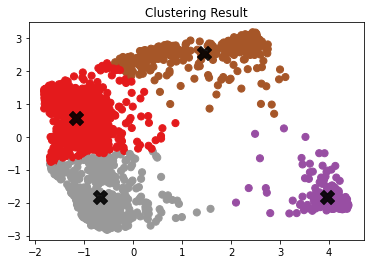

In [162]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='Set1') # Plot data points based on the cluster allocation
centers = kmeans.cluster_centers_ # Get cluster center info 
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=200, alpha=0.9); # Plot the cluseter center as the black X
plt.title('Clustering Result')

For n_clusters = 2 The average silhouette_score is : 0.5192185534224789
For n_clusters = 3 The average silhouette_score is : 0.5742534660725178
For n_clusters = 4 The average silhouette_score is : 0.5757087761052094
For n_clusters = 5 The average silhouette_score is : 0.5385399299587695
For n_clusters = 6 The average silhouette_score is : 0.5554522366487209
For n_clusters = 7 The average silhouette_score is : 0.5255804499371413
For n_clusters = 8 The average silhouette_score is : 0.5172754791693693


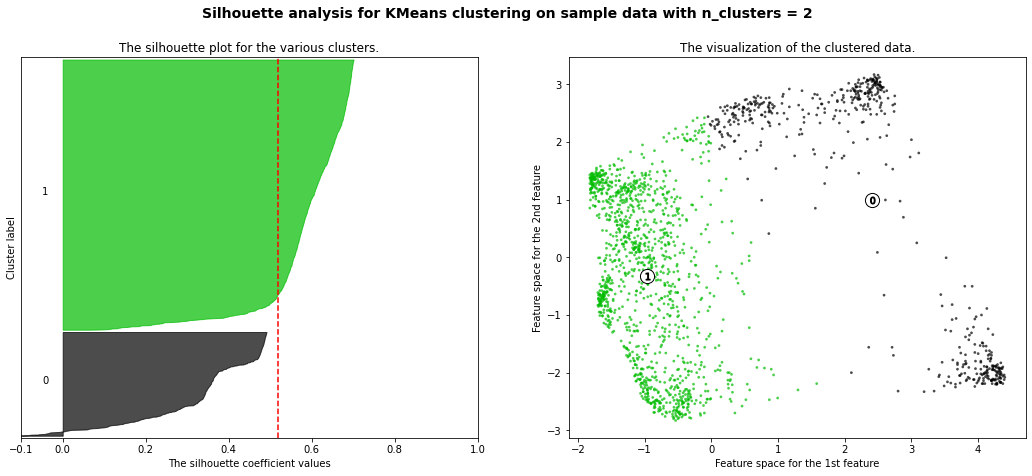

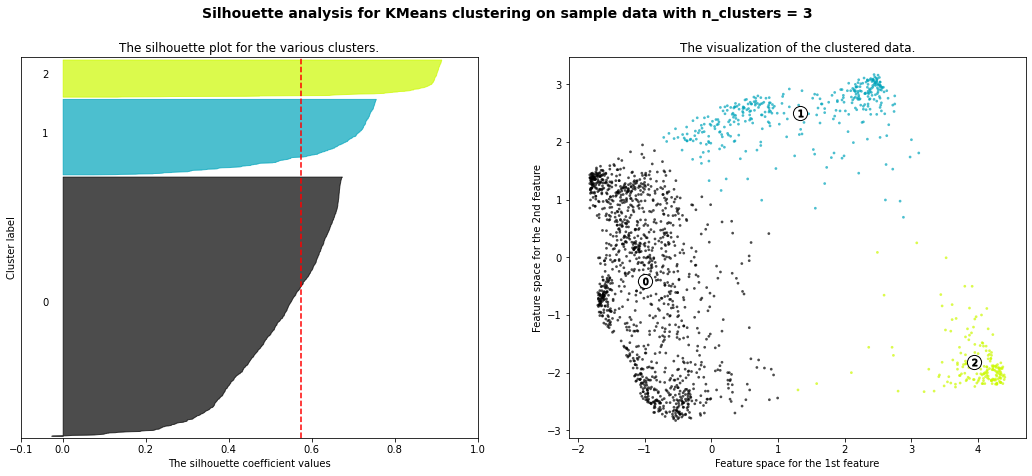

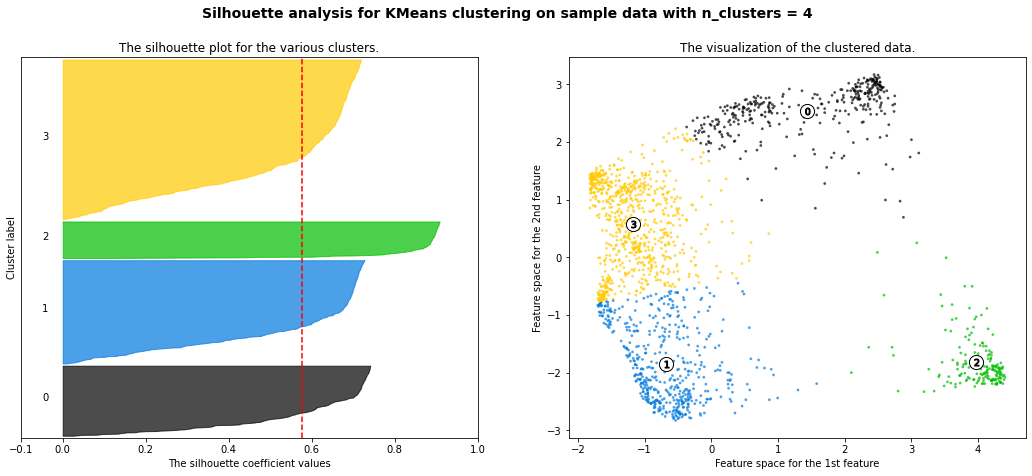

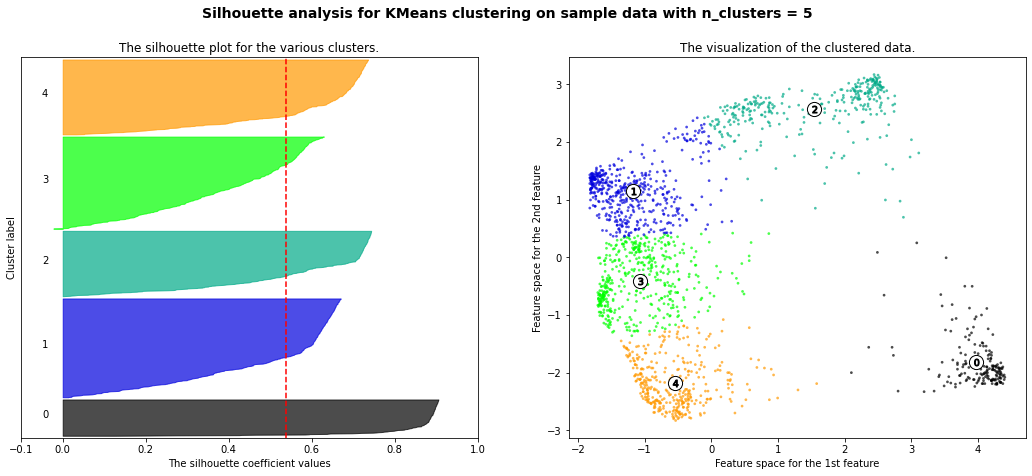

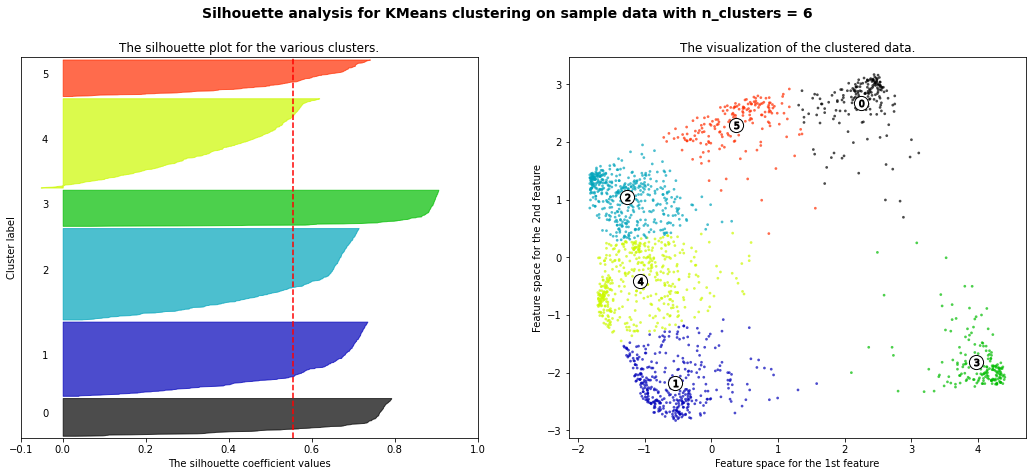

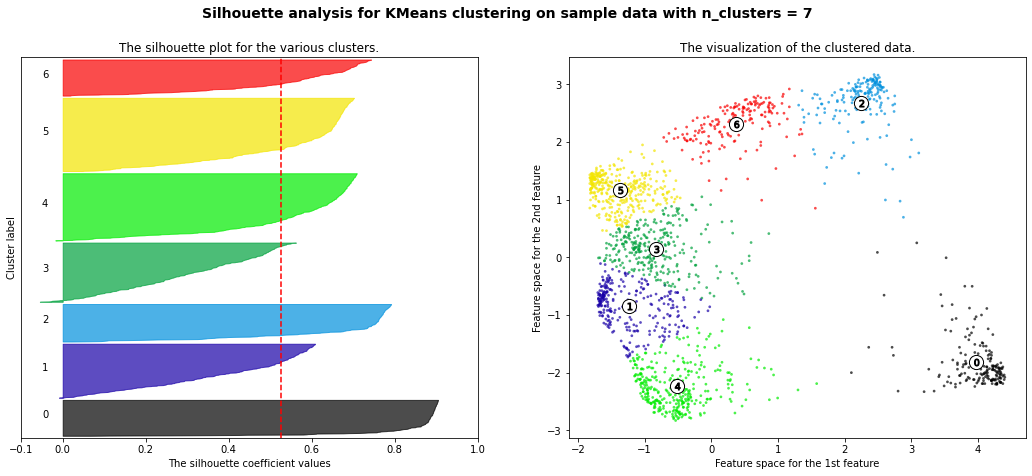

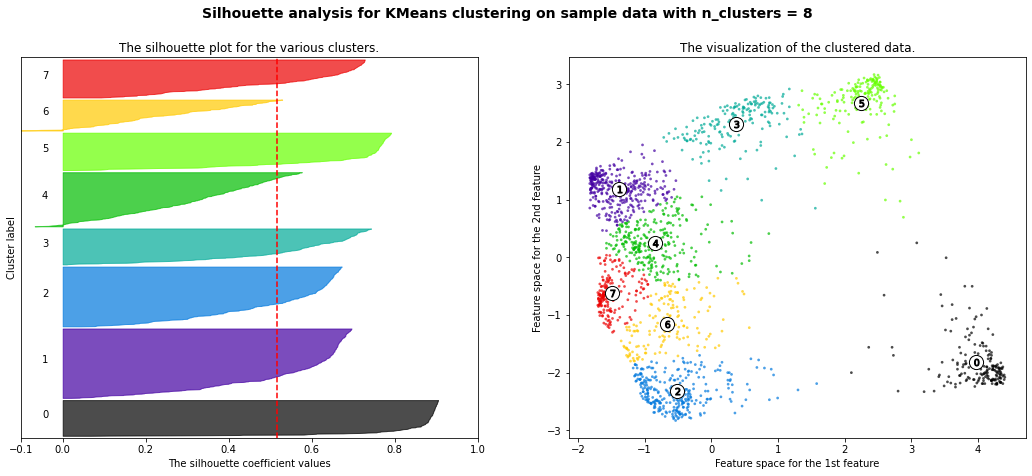

In [245]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Hierarchical-based Clustering (AGNES)

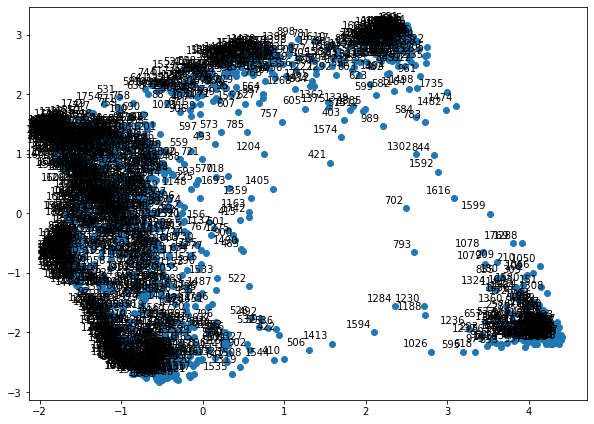

In [5]:
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

labels = range(1, 1797)
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(X[:,0],X[:,1], label='True Position')

for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

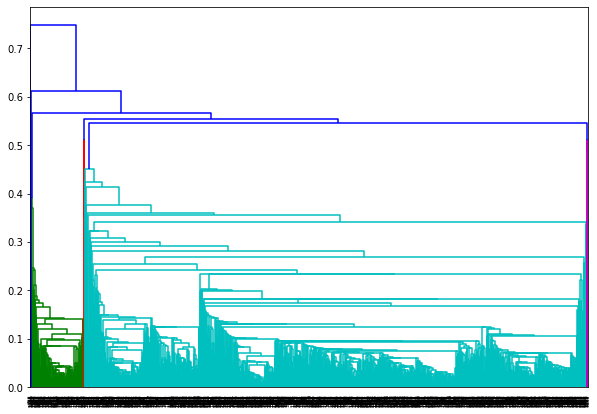

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

labelList = range(1, 1798)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [141]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
cluster.fit_predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [142]:
print(cluster.labels_)

[0 0 0 ... 0 0 0]


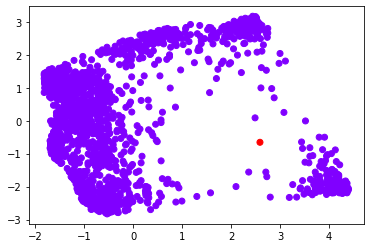

In [143]:
plt.scatter(X[:,0],X[:,1], c=cluster.labels_, cmap='rainbow')

In [144]:
from sklearn import metrics
labels = cluster.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.162


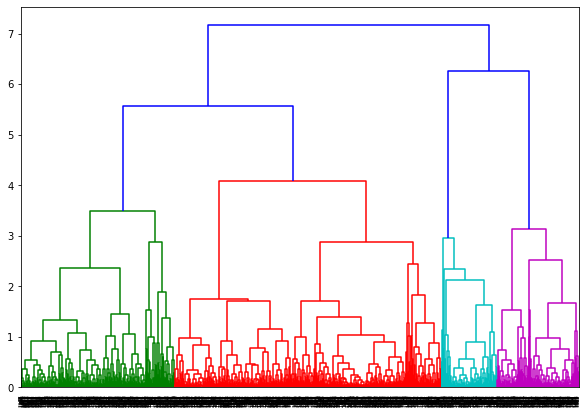

In [74]:
linked = linkage(X, 'complete')

labelList = range(1, 1798)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [121]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
cluster.fit_predict(X)

array([2, 0, 0, ..., 0, 1, 0], dtype=int64)

In [122]:
print(cluster.labels_)

[2 0 0 ... 0 1 0]


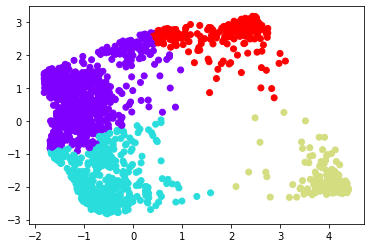

In [123]:
plt.scatter(X[:,0],X[:,1], c=cluster.labels_, cmap='rainbow')

In [124]:
from sklearn import metrics
labels = cluster.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.546


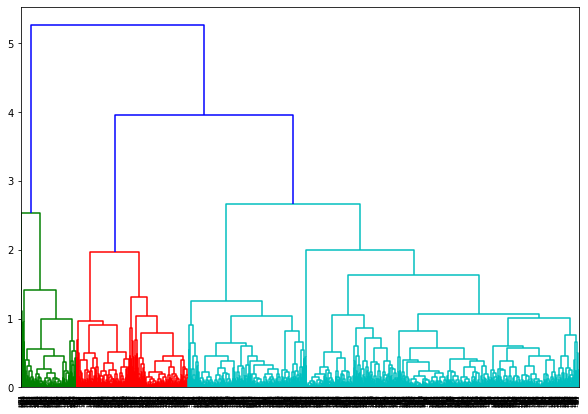

In [108]:
linked = linkage(X, 'average')

labelList = range(1, 1798)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [118]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
cluster.fit_predict(X)

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

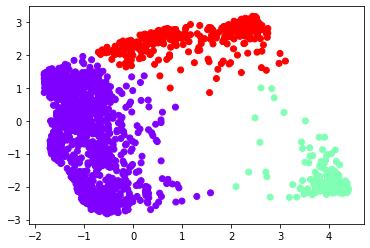

In [119]:
plt.scatter(X[:,0],X[:,1], c=cluster.labels_, cmap='rainbow')

In [120]:
from sklearn import metrics
labels = cluster.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.573


## Density-based Clustering (DBSCAN)

In [37]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_frame)
    distortions.append(kmeanModel.inertia_)

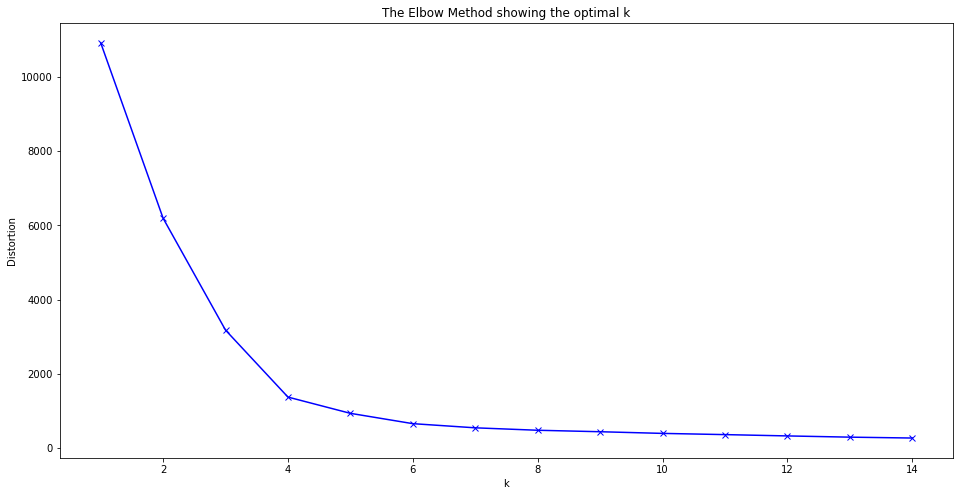

In [38]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<ipython-input-43-aa62ae0093c3>:5: RuntimeWarning: invalid value encountered in sqrt
  p = np.sqrt(p)


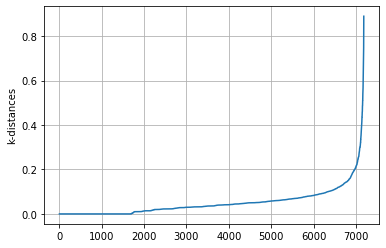

In [43]:
def k_distances2(x, k):
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p=-2*x.dot(x.T)+np.sum(x**2, axis=1).T+ np.repeat(np.sum(x**2, axis=1),dim0,axis=0).reshape(dim0,dim0)
    p = np.sqrt(p)
    p.sort(axis=1)
    p=p[:,:k]
    pm= p.flatten()
    pm= np.sort(pm)
    return p, pm
m, m2= k_distances2(X, 4)
plt.plot(m2)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

In [246]:
import math
def calculate_kn_distance(X,k):

    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(
                math.sqrt(
                    ((X[i,0] - X[j,0]) ** 2) +
                    ((X[i,1] - X[j,1]) ** 2)))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

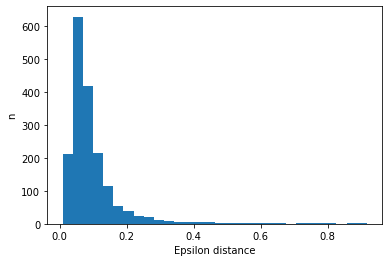

In [250]:
eps_dist = calculate_kn_distance(X,4)
plt.hist(eps_dist,bins=30)
plt.ylabel('n');
plt.xlabel('Epsilon distance');

In [3]:
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# predict using DBSCAN with Eps = 0.2 and minPts = 10
y_pred = DBSCAN(eps=0.35, min_samples=12).fit_predict(X)
print(y_pred)

[0 1 1 ... 1 1 1]


Number of clusters: 3


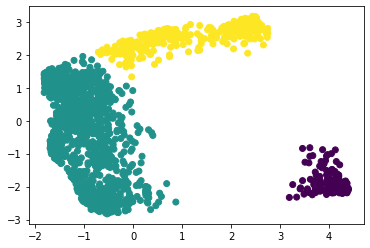

In [6]:
# Plot the results
plt.scatter(X[np.where(y_pred != -1),0], X[np.where(y_pred != -1),1], c=y_pred[np.where(y_pred != -1)])
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))

In [167]:
from sklearn import metrics
y_pred = DBSCAN(eps=0.25, min_samples=7).fit(X)
labels = y_pred.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(n_clusters_)
print(n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

3
81
Silhouette Coefficient: 0.479


In [51]:
from sklearn import metrics
y_pred = DBSCAN(eps=0.35, min_samples=12).fit(X)
labels = y_pred.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(n_clusters_)
print(n_noise_)
y_pred = DBSCAN(eps=0.35, min_samples=12).fit_predict(X)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X[np.where(y_pred != -1)], y_pred[np.where(y_pred != -1)]))

3
59
Silhouette Coefficient: 0.587


In [49]:
from sklearn.metrics import silhouette_samples, silhouette_score
# range_eps = [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4]
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step
        
largest = 0     
largestlabels = 0
for i in frange(0.2, 0.4, 0.01):
    print("eps value is " + str(i))
#     db = DBSCAN(eps=i, min_samples=9).fit(X)
#     core_sample_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_sample_mask[db.core_sample_indices_] = True
#     labels = db.labels_
#     print(set(labels))
    y_pred = DBSCAN(eps=i, min_samples=24).fit_predict(X)
    silhouette_avg = silhouette_score(X[np.where(y_pred != -1)], y_pred[np.where(y_pred != -1)])
    if silhouette_avg > largest:
        largest = silhouette_avg
        largesti = i
    print("For eps value ="+str(i), labels,
         "The average silhouette_score is: ", silhouette_avg)
print(largesti, largest)

eps value is 0.2
For eps value =0.2 [ 0  1  1 ...  1 -1 -1] The average silhouette_score is:  0.6202146257301877
eps value is 0.21000000000000002
For eps value =0.21000000000000002 [ 0  1  1 ...  1 -1 -1] The average silhouette_score is:  0.45546132824285107
eps value is 0.22000000000000003
For eps value =0.22000000000000003 [ 0  1  1 ...  1 -1 -1] The average silhouette_score is:  0.6409528098618407
eps value is 0.23000000000000004
For eps value =0.23000000000000004 [ 0  1  1 ...  1 -1 -1] The average silhouette_score is:  0.6230587270988042
eps value is 0.24000000000000005
For eps value =0.24000000000000005 [ 0  1  1 ...  1 -1 -1] The average silhouette_score is:  0.6136818420088171
eps value is 0.25000000000000006
For eps value =0.25000000000000006 [ 0  1  1 ...  1 -1 -1] The average silhouette_score is:  0.5867804989657935
eps value is 0.26000000000000006
For eps value =0.26000000000000006 [ 0  1  1 ...  1 -1 -1] The average silhouette_score is:  0.5273233637197874
eps value is 0.2